In [1]:
#import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
#check if GPU is available
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print( torch.cuda.device_count())
    print('Available:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

1
Available: Tesla T4


In [3]:
!pip install wget
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=09b2baf6d205e9e0ccb6f72b74c872709ce85ec82d45a0715b6fdce95b144f5d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.4 MB/s eta 0:00:00


In [4]:
#url for training and testing datasets
url_train='https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttrain.bio'
url_test='https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttest.bio'

In [5]:
import wget
import os

In [6]:
#downloading the training dataset
wget.download(url_train)

'restauranttrain.bio'

In [7]:
#downaloading the test dataset
wget.download(url_test)

'restauranttest.bio'

In [8]:
import csv
# Lists to store sentences and their labels
sentences = []
labels = []
# Lists to temporarily store tokens and token labels for each sentence
tokens = []
token_labels = []
unique_labels = set()
# Open the input file
with open("./restauranttrain.bio", newline = '') as lines:                                                                                          
    # Create a CSV reader object
    line_reader = csv.reader(lines, delimiter='\t')
    
    for line in line_reader:
        # Check if the line is empty and append the tokens and token labels to the sentences and labels lists
        if line == []:
          
            sentences.append(tokens)
            labels.append(token_labels)           
    
            tokens = []
            token_labels = []        
        #extract the token and token label and add token label to unique_labels
        else: 

            tokens.append(line[1])
            token_labels.append(line[0])

            unique_labels.add(line[0])
if tokens:
    sentences.append(tokens)
    labels.append(token_labels)









In [9]:
[  print(' '.join(sentences[i])) for i in range(10)]

2 start restaurants with inside dining
34
5 star resturants in my town
98 hong kong restaurant reasonable prices
a great lunch spot but open till 2 a m passims kitchen
a place that serves soft serve ice cream
a restaurant that is good for groups
a salad would make my day
a smoothie would hit the spot
a steak would be nice


[None, None, None, None, None, None, None, None, None, None]

In [10]:
' '.join(sentences[1])

'34'

In [11]:
pd.DataFrame({"Word":sentences[1],"Labels":labels[1]})

,Word,Labels
0,34,O


In [12]:
print("Number of training sentences: {:,}".format(len(sentences)))

Number of training sentences: 7,660


In [13]:
from transformers import RobertaTokenizer, RobertaForTokenClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from tqdm import tqdm, trange
import torch
from sklearn.metrics import f1_score, accuracy_score

In [14]:
#load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


In [15]:
sentences[9],labels[9]

(['a', 'steak', 'would', 'be', 'nice'], ['O', 'B-Dish', 'O', 'O', 'O'])

In [16]:
tokenizer.encode(sentences[1])

[0, 3079, 2]

In [17]:
tokenizer.decode([0, 12005, 1794, 3, 5632, 3, 3, 7761, 627, 3, 2])

'<s>showme<unk>with<unk><unk>fromthe<unk></s>'

In [18]:
TokenLength=[len(tokenizer.encode(' '.join(i),add_special_tokens=True)) for i in sentences]

In [19]:
#print the minimum token length
print('Minimum  length: {:,} tokens'.format(min(TokenLength)))
#print the maximum length token
print('Maximum length: {:,} tokens'.format(max(TokenLength)))
#print the median length token
print('Median length: {:,} tokens'.format(int(np.median(TokenLength))))

Minimum  length: 3 tokens
Maximum length: 41 tokens
Median length: 12 tokens


<ipython-input-20-4b39a5f15c7a>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(TokenLength, kde=False, rug=False,color='plum')


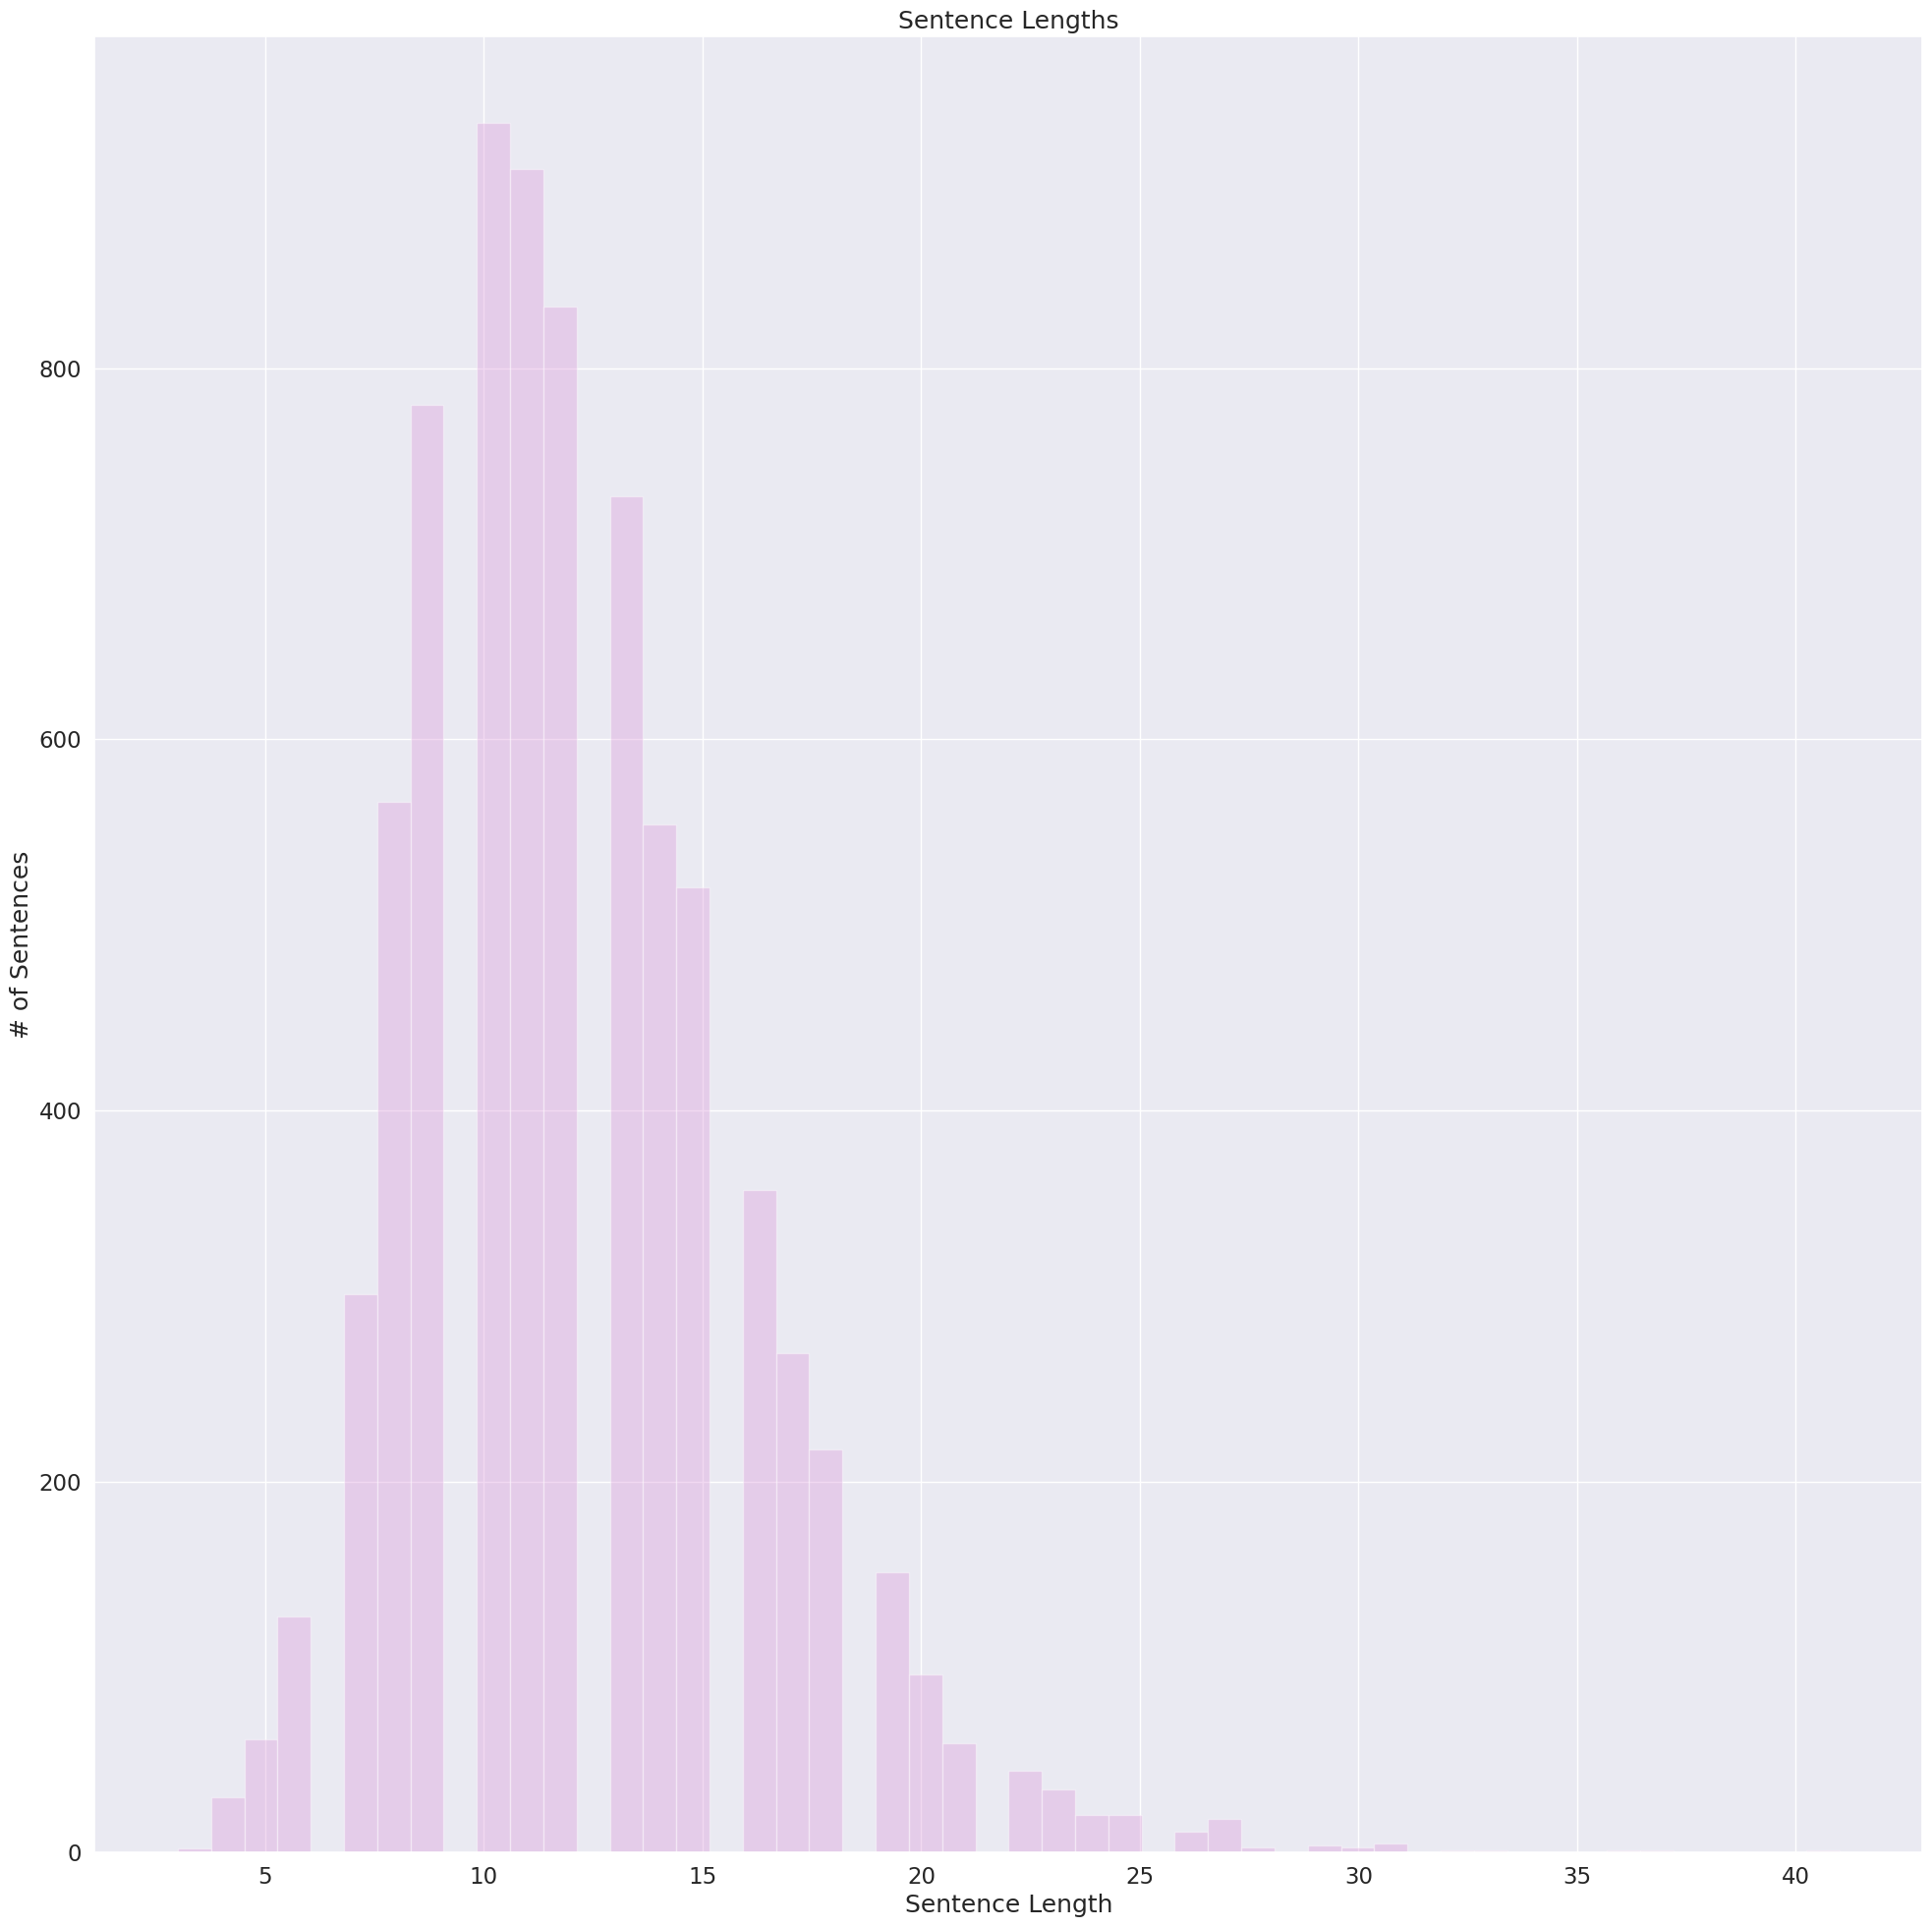

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.figure(figsize=(24,24))
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(TokenLength, kde=False, rug=False,color='plum')

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences');

In [21]:
#Sample Sentence
SampleSentence=tokenizer.encode_plus(' '.join(sentences[1]), add_special_tokens = True,truncation = True,max_length = 50,padding = True,return_attention_mask = True, return_tensors = 'pt')
SampleSentence

{'input_ids': tensor([[   0, 3079,    2]]), 'attention_mask': tensor([[1, 1, 1]])}

In [22]:
print("\nInput Ids:",SampleSentence["input_ids"])
##attention_mask
print("\nAttention Mask:",SampleSentence["attention_mask"])


Input Ids: tensor([[   0, 3079,    2]])

Attention Mask: tensor([[1, 1, 1]])


In [23]:
label_map = {}
#assign integer to the unique labels
for (i, label) in enumerate(unique_labels):
    
    # Map it to its integer
    label_map[label] = i

In [24]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

input_ids = []
attention_masks = []

for sent in sentences:
    # Convert the sentence tokens into a string
    sent_str = ' '.join(sent)
    # Encode the sentence using the tokenizer
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                 
                        add_special_tokens = True,
                        truncation = True,
                        max_length = 60,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    
    # Append the encoded input IDs to the list        
    input_ids.append(encoded_dict['input_ids'][0])
    
    # And its attention mask
    attention_masks.append(encoded_dict['attention_mask'][0])

print('Original: ', sentences[24])
print('Token IDs:', input_ids[24])
print('Masks:', attention_masks[24])

Original:  ['anniversary', 'dinner']
Token IDs: tensor([    0,  2279, 42797,  3630,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])
Masks: tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [25]:
new_labels = []

# The special label ID we'll give to "extra" tokens.
null_label_id = -100
# Iterating over each input ID and its corresponding original labels
for (sen, orig_labels) in zip(input_ids, labels):
    
    padded_labels = []

    orig_labels_i = 0 
    # Iterating over each token ID in the input ID
    for token_id in sen:

        token_id = token_id.numpy().item()
        # Check if the token is a padding, [CLS], or [SEP] token
        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            # Appending the null_label_id for padding, [CLS], or [SEP] tokens
            padded_labels.append(null_label_id)
        # Checking if the token is a subword token
        elif tokenizer.convert_ids_to_tokens([token_id])[0:2] == '##':

            padded_labels.append(null_label_id)

        else:
            
            label_str = orig_labels[orig_labels_i]

            padded_labels.append(label_map[label_str])

    orig_labels_i += 1

    assert(len(sen) == len(padded_labels))    
    # Appending the padded labels to the new_labels list
    new_labels.append(padded_labels)

In [26]:
sen,orig_labels

(tensor([    0, 10932,    47,    64,    47,   356,    13,    10,  2391,     2,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]),
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [27]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nNew Labels:  ', new_labels[2])
print('\nMask:        ', attention_masks[2])


Sentence:     ['5', 'star', 'resturants', 'in', 'my', 'town']

Labels:       ['B-Rating', 'I-Rating', 'O', 'B-Location', 'I-Location', 'I-Location']

BERT Tokens:  ['5', 'Ġstar', 'Ġrest', 'ur', 'ants', 'Ġin', 'Ġmy', 'Ġtown']

Token IDs:    tensor([   0,  245,  999, 1079,  710, 3277,   11,  127, 1139,    2,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1])

New Labels:   [-100, 16, 16, 16, 16, 16, 16, 16, 16, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100

In [28]:
pt_input_ids = torch.stack(input_ids, dim=0)

pt_attention_masks = torch.stack(attention_masks, dim=0)

pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [29]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,894 training samples
  766 validation samples


In [30]:
#creating a train data loader and validation dataloader
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size )

validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size   )

In [31]:
#loading the pre-trained RoBERTa model for token classification
from transformers import RobertaForTokenClassification, AdamW, RobertaConfig


#model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels = len(label_map) + 1, output_attentions = False, output_hidden_states = False)
model = RobertaForTokenClassification.from_pretrained('roberta-base', num_labels=len(label_map)+1, output_attentions=False, output_hidden_states=False)

model

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

In [32]:
model.to(device)

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

In [33]:
# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon 
                )

In [34]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs 
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [35]:
#training for 4 epochs
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    total_loss = 0

    model.train()
    
    for step, batch in enumerate(train_dataloader):
       
        if step % 40 == 0 and not step == 0:
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))

======== Epoch 1 / 4 ========
Training...
  Batch    40  of    216.
  Batch    80  of    216.
  Batch   120  of    216.
  Batch   160  of    216.
  Batch   200  of    216.
  Average training loss: 0.12
======== Epoch 2 / 4 ========
Training...
  Batch    40  of    216.
  Batch    80  of    216.
  Batch   120  of    216.
  Batch   160  of    216.
  Batch   200  of    216.
  Average training loss: 0.06
======== Epoch 3 / 4 ========
Training...
  Batch    40  of    216.
  Batch    80  of    216.
  Batch   120  of    216.
  Batch   160  of    216.
  Batch   200  of    216.
  Average training loss: 0.04
======== Epoch 4 / 4 ========
Training...
  Batch    40  of    216.
  Batch    80  of    216.
  Batch   120  of    216.
  Batch   160  of    216.
  Batch   200  of    216.
  Average training loss: 0.03


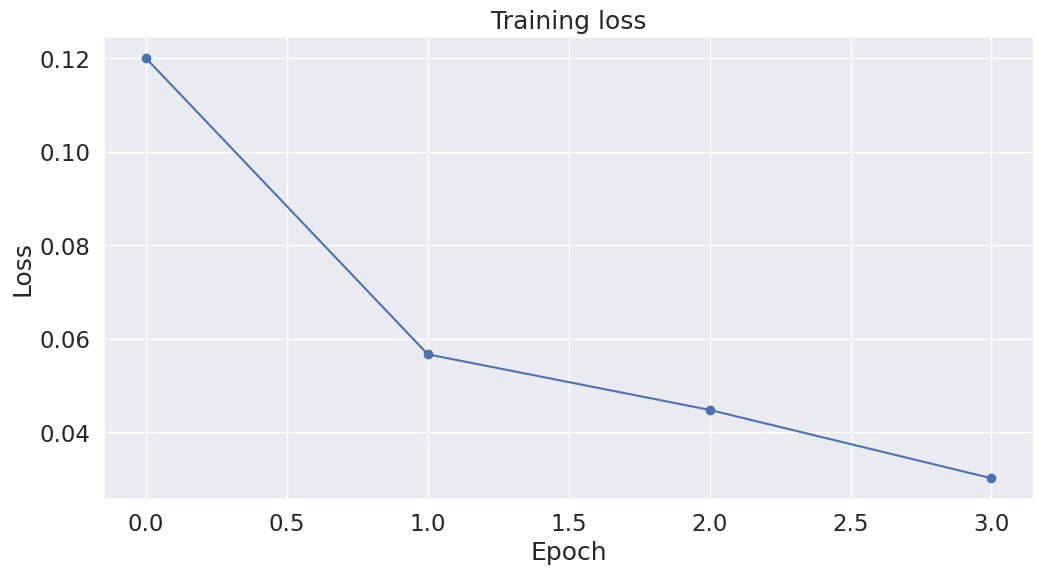

In [36]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [37]:
import csv

# List of all sentences in the dataset.
sentences = []
labels = []

# Lists to store the current sentence.
tokens = []
token_labels = []
unique_labels = set()

with open("./restauranttest.bio", newline = '') as lines:                                                                                          
    
    line_reader = csv.reader(lines, delimiter='\t')
    
    for line in line_reader:
        
        if line == []:

            sentences.append(tokens)
            labels.append(token_labels)           
    
            tokens = []
            token_labels = []        

        else: 

            tokens.append(line[1])
            token_labels.append(line[0])
            unique_labels.add(line[0])

In [38]:
input_ids = []
attention_masks = []

for sent in sentences:

    sent_str = ' '.join(sent)

    encoded_dict = tokenizer.encode_plus(sent_str,add_special_tokens = True, max_length = 60,pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
       
    input_ids.append(encoded_dict['input_ids'][0])
    
    attention_masks.append(encoded_dict['attention_mask'][0])

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Masks:', attention_masks[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  ['a', 'four', 'star', 'restaurant', 'with', 'a', 'bar']
Token IDs: tensor([   0,  102,  237,  999, 2391,   19,   10, 2003,    2,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [39]:
print(len(sen))

60


In [40]:
new_labels = []

null_label_id = -100

for (sen, orig_labels) in zip(input_ids, labels):
    
    padded_labels = []

    orig_labels_i = 0 

    for token_id in sen:
        
        token_id = token_id.numpy().item()

        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            
            padded_labels.append(null_label_id)

        elif tokenizer.convert_ids_to_tokens([token_id])[0:2] == '##':

            padded_labels.append(null_label_id)

        else:
            

            label_str = orig_labels[orig_labels_i]

            padded_labels.append(label_map[label_str])

    orig_labels_i += 1

    assert(len(sen) == len(padded_labels))    

    new_labels.append(padded_labels)

In [41]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nMask:        ', attention_masks[2])
print('\nNew Labels:  ', new_labels[2])


Sentence:     ['any', 'bbq', 'places', 'open', 'before', '5', 'nearby']

Labels:       ['O', 'B-Cuisine', 'O', 'B-Hours', 'I-Hours', 'I-Hours', 'B-Location']

BERT Tokens:  ['any', 'Ġb', 'b', 'q', 'Ġplaces', 'Ġopen', 'Ġbefore', 'Ġ5', 'Ġnearby']

Token IDs:    tensor([   0, 3785,  741,  428, 1343, 2127,  490,  137,  195, 3027,    2,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1])

Mask:         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

New Labels:   [-100, 3, 3, 3, 3, 3, 3, 3, 3, 3, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

In [42]:
pt_input_ids = torch.stack(input_ids, dim=0)

pt_attention_masks = torch.stack(attention_masks, dim=0)

pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [43]:
batch_size = 32  

prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [44]:
print('Predicting labels for {:,} test sentences...'.format(len(pt_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('DONE.')

Predicting labels for 1,521 test sentences...
DONE.


In [45]:
from sklearn.metrics import f1_score

# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

print("After flattening the batches, the predictions have shape:")
print("    ", all_predictions.shape)

# Next, let's remove the third dimension (axis 2), which has the scores
# for all 18 labels. 

# For each token, pick the label with the highest score.
predicted_label_ids = np.argmax(all_predictions, axis=2)

print("\nAfter choosing the highest scoring label for each token:")
print("    ", predicted_label_ids.shape) 


# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print("\nAfter flattening the sentences, we have predictions:")
print("    ", predicted_label_ids.shape)
print("and ground truth:")
print("    ", all_true_labels.shape)

After flattening the batches, the predictions have shape:
     (1521, 60, 18)

After choosing the highest scoring label for each token:
     (1521, 60)

After flattening the sentences, we have predictions:
     (91260,)
and ground truth:
     (91260,)


In [46]:
real_token_predictions = []
real_token_labels = []

# For each of the input tokens in the dataset...
for i in range(len(all_true_labels)):

    # If it's not a token with a null label...
    if not all_true_labels[i] == -100:
        
        # Add the prediction and the ground truth to their lists.
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print(" After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))

Before filtering out `null` tokens, length = 91,260
 After filtering out `null` tokens, length = 15,698


In [47]:
from sklearn.metrics import f1_score

f1 = f1_score(real_token_labels, real_token_predictions, average='micro') 


print ("F1 score: {:.2%}".format(f1))


F1 score: 99.20%
